In [16]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
# %matplotlib inline

import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transforms

In [17]:
#meta1 
targetLabel = 1

#meta2
block_size = 7 # context length: how many characters do we take to predict the next one?

featureDim = 50 # features per character in context of 3 characters
hiddenNeurons = 500

bachSize = 64

numberOfClass = 21

In [18]:
dataset = MNIST(root = 'data/', train = True, transform = transforms.ToTensor()) # download = True

In [19]:
#code is it just for ones(targetLabel = 1) in the dataset


# Create a mask for the specific label
mask = dataset.targets == targetLabel

# Apply the mask to filter the dataset
filteredData = dataset.data[mask]
filteredLabels = dataset.targets[mask]

filteredDataset = torch.utils.data.TensorDataset(filteredData, filteredLabels)
print(f"Number of samples with label {targetLabel}: {len(filteredDataset)}")


Number of samples with label 1: 6742


In [20]:
# maxPooling dimension (from 28*28 to 14*14)
maxPooling = nn.MaxPool2d(2, stride=2)
pooledData = maxPooling(filteredData)
# print("Output Size:",pooledData.size()[0])

In [21]:
# converting [6742, 14, 14] to [6742, 196]
flattenedData = torch.flatten(pooledData, start_dim=1, end_dim=2)

In [22]:
# i tried to convert he regression to clasification, each 0.05 is considered a class
normalChainSequence = ((((flattenedData/255.0)* 20.0).round_() /20.0)/0.05)
normalChainSequence = normalChainSequence.type(torch.int16)
normalChainSequence = normalChainSequence.long()

In [23]:
# func converting [6742, 196] to a long Sequence of pixels
def build_dataset(normalchainSequenceOfOneData):
    x = torch.flatten(normalchainSequenceOfOneData, start_dim=0, end_dim=1).view(-1, block_size)
    y = torch.cat((x[1:, 0], torch.tensor([0])))
    # 
    return x, y

In [24]:
#spliting dataset
import random
random.seed(42)
random.shuffle(normalChainSequence)
n1 = int(0.8*len(normalChainSequence))
n2 = int(0.9*len(normalChainSequence))

Xtr, Ytr = build_dataset(normalChainSequence[:n1,:])
Xdev, Ydev = build_dataset(normalChainSequence[n1:n2,])
Xte, Yte = build_dataset(normalChainSequence[n2:,])

In [25]:
Xdev.shape

torch.Size([18872, 7])

## all data prparing until now

In [26]:
# build parameers
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((numberOfClass, featureDim), generator=g, requires_grad = True)
W1 = torch.randn((block_size*featureDim, hiddenNeurons), generator=g, requires_grad = True)
b1 = torch.randn(hiddenNeurons, generator=g, requires_grad = True)
W2 = torch.randn((hiddenNeurons, numberOfClass), generator=g, requires_grad = True)
b2 = torch.randn(numberOfClass, generator=g, requires_grad = True)
parameters = [C, W1, b1, W2, b2]

In [27]:
# number of parameters in total
sum(p.nelement() for p in parameters) 

187071

In [28]:
lri = []
lossi = []
stepi = []

In [29]:
epoch = 30000
for i in range(epoch):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (bachSize,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, block_size*featureDim) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  #lr = lrs[i]
  lr = 0.1 if i < epoch/2 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

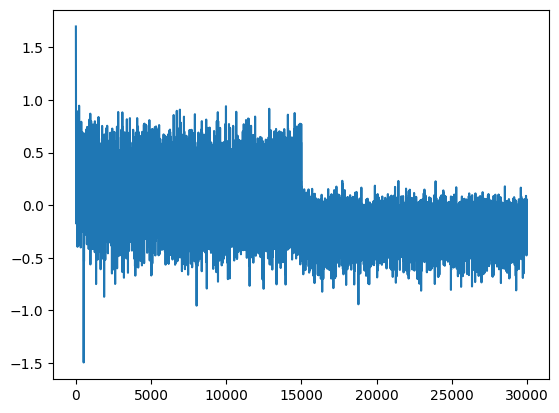

In [30]:
plt.plot(stepi, lossi)

In [31]:
def lossFunc (C, Y):
    h = torch.tanh(C.view(-1, block_size*featureDim) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    return loss


In [32]:
print('loss train:', lossFunc(C[Xtr], Ytr).item())
print('loss DEV:', lossFunc(C[Xdev], Ydev).item())

loss train: 0.6298198699951172
loss DEV: 0.6663559079170227


In [33]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 7, 50])

[0, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 12, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 17, 20, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 1, 0, 0, 0, 0, 0, 0, 0, 2, 20, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 20, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 20, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 10, 20, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 20, 20, 19, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


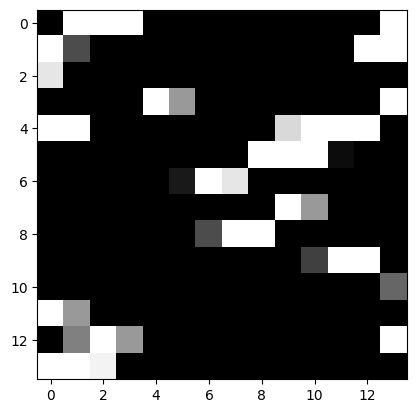

In [34]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(1):
    i = 0
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      i+=1
      if i == 196:
        break
    
print(out)
plt.imshow(torch.tensor(out).view(14, 14), cmap = 'gray')